# Introduction to Finetuning a Pytorch Pretrained Model using an Arbitrary Number of Classes

In this post we are going to take a [Pytorch model](https://pytorch.org/vision/stable/models.html) that has been pre-trained on [Imagenet](https://image-net.org/) (with 100 classes) and fine tune it on a different dataset (CIFAR2) with a 2 classes.

This post is aimed at those who are familiar with Jupyter, Python and Deep Learning concepts in general eg Tensorflow or FastAI users. If you are not already familiar with Deep Learning you may find [Practical Deep Learning for Coders](https://course.fast.ai) by Jeremy Howard and Sylvain Gugger to be an excellent introduction to both the [Fast AI library](https://www.fast.ai/) and to deep learning in general.

While not included in this example; the use of a tracking system, such as the open source  [MLFlow](https://mlflow.org/), to log results during training and to store the resulting model would be best practice and provides many benefits over the print out methods demonstrated here. 

The training and dataset creation have been deliberately kept streamlined in order to show the concepts involved, in a real situation additional work would be needed to ensure reliability and robust functioning.


## Reproducing

This code was tested on enviroment [E037](https://github.com/kierenAW/conda_environments_for_data_science) using Jupyter Lab

## Import Pytorch Libraries

In [1]:
import torch
import torchvision as tv
import numpy as np
from PIL import Image
from IPython.display import Image as IpyImg
import matplotlib.pyplot as plt

## Helper Function

In [2]:
def get_device():
    """Set as GPU if available, else set CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


## Set Parameters
We start by setting hyper-parameters first, using variables allows these to be easily updated later during hyper-parameter tuning. Later on we will instantiate the the PyTorch objects we need later using these variables.

### Device
PyTorch works well with Cuda for acceleration so if you have a compatible GPU and the correct NVIDIA drivers that support the version of Cuda matching the version of PyTorch; then the helper function will set the device to be <i>GPU</i> otherwise it will be <i>CPU</i>. 

In [3]:
device = get_device()

In [4]:
device

device(type='cuda')

### Model
The model we will use for this task will be a [Resnet18](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) due to it's realtivly small size and good performance. This could be changed later as part of optimising, either by selecting a smaller model for cheaper training/inference or a larger model to improve accuracy.

In [5]:
model_name = 'resnet18'

### Learning Rate
Next we will set a fairly small learning rate as we will be using a small batch size and, as the model is pretrained, we want to fine tune it for our problem. The Learning Rate will probably need adjusting to find an optimal point but, again, this can be optimised later.

In [6]:
learning_rate = 0.001

### Loss
[CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) will provide what we need for this binary classifcation task. The loss function can be changed to suit the situation however it is out of scope for this blog post.

In [7]:
loss_name = 'CrossEntropyLoss'

### Batch Size

This task works well with very small batches which also makes the example suitable for use on GPU's with limited RAM

In [8]:
batch_size = 4

### Classes

The dataset we will use will have 2 labels from cifar2 so we set this to match. In other tasks this number would simply be set to the desired number of output classes.

In [9]:
num_class = 2

## Set Epochs for Training the Model

This is a realatively simple task for the pretrained model, we have selected 10 epochs so this should provide plenty of time to fine tune. This value would need to be tuned or the use of [Early Stoping](https://en.wikipedia.org/wiki/Early_stopping) might be useful but is outside the scope of this post.

In [10]:
last_layer_epochs = 2
all_layer_epochs = 15

## Load Pretrained Model

See [torchvision.models](https://pytorch.org/vision/stable/models.html) for details on model's and the PyTorch Modelk zoo.

This method will work with ResNet architecture as the last layer is named 'fc', the code could be adapted to suit other model architectures by referencing the last named layer.

First we load the pretrained model as-is and then modify it to suit our usecase.

In [11]:
model = tv.models.__dict__[model_name](pretrained=True)

## Review the Model

Here we display the model so we can see how it is designed, this step is just for interest and can be disabled during training.

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Create New Output Layer

We replace the single Linear output layer with a Sequential (sub)model that includes 2 linear layers seperated by a [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) then ending in a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html?highlight=softmax) function.

The last layer of this model is called 'fc' so we reference this layer by nameto replace it with our new output layers.

More information is availalbe in the [Pytorch documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

In [13]:
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=512, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512, out_features=2, bias=True),
    torch.nn.Softmax(dim = 1)
)

## Look at the Updated Model

Again, lets display the model but this time in its new state so we can see our changes, this step is just for interest and can be disabled during training.

In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Send the Model to the Device in Use

To ensure we use a GPU (if available) we need to send the model to the device set earlier, PyTorch allows this to be manually controlled which provides great flexibility.

In [15]:
model = model.to(device)

## Setup the Loss Function
A [criterion](https://www.merriam-webster.com/dictionary/criterion) or loss function object is created using a [Pytorch Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions) and the variables we defined earlier.

In [16]:
loss_fn = torch.nn.__dict__[loss_name]()

## Setup optimiser 
Using the [torch.optim](https://pytorch.org/docs/stable/optim.html) class we create an optimizer object with the value we defined earlier.

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Create the Transforms Object

This is where datasets augmentation can be performed, in this example we won't be doing this but we do need to change the images to be a PyTorch tensor and normalise the data to match the image-net pre-training on the model we choose earlier.

In [18]:
data_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Get a Dataset

Torchvision has a range of image based [datasets](https://pytorch.org/vision/0.8/datasets.html) available to use, we will be crating CIFAR2 from [Cifar10](https://pytorch.org/vision/stable/datasets.html#cifar). PyTorch has built in methods to download and access the data using the <i>torchvision.datasets.CIFAR10</i> class and we will use this as an initial source for our data.

CIFAR10 Has 10 balanced classes which are:

0. Airplane
0. Automobile
0. Bird
0. Cat
0. Deer
0. Dog
0. Frog
0. Horse
0. Ship
0. Truck

In this example we will select the first two classes (Planes and Cars) and create a binary classifcation task. 

To load and feed data to the data loader PyTorch we extend the <i>torch.utils.data.Dataset</i> class and create the __\_\_len\_\___ and __\_\_getitem\_\___ methods to return each element of the dataset.

In [19]:
class cifar_bin_dataset(torch.utils.data.Dataset):

    def __init__(self, train_set, data_transforms):
        'Initialization'
        
        self.data_transform = data_transforms
        
        #Import the cifar10 data, we will be accessing this to get thje data we need
        cifar10_dataset_obj = tv.datasets.CIFAR10(root='.', train=train_set, download=True)
        
        self.image_array = cifar10_dataset_obj.data
        
        self.number_class_targets = int(len(cifar10_dataset_obj.targets)/10) #Get the number of examples of each class
        
        plane_idx =  [i for i, value in enumerate(cifar10_dataset_obj.targets) if value == 0]
        
        car_idx = [i for i, value in enumerate(cifar10_dataset_obj.targets) if value == 1]
        
        self.idx_list = plane_idx + car_idx
              
        self.target_tensor = np.concatenate(
         (np.zeros(self.number_class_targets),
          np.ones(self.number_class_targets)),
         axis=0
        ).astype(np.float32)
        
    def __len__(self):
        'Denotes the total number of samples'
             
        return len(self.idx_list)

             
    def __getitem__(self, index):
        'Generates one sample of data'
              
        img = Image.fromarray(self.image_array[self.idx_list[index]]) #turn the np array into a PIL image to simulate  
        
        return  data_transforms(img), int(self.target_tensor[index])


## Instantiate Dataset Class

In [20]:
train_dataset = cifar_bin_dataset(True, data_transforms)
val_dataset = cifar_bin_dataset(False, data_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Review Dataset

The exploration of data is a vital first step so here we create a function to print out the image and assocated label. 

The dataset can be accessed directly using the index from the __\_\_getitem_\_\___ methods we created in the \_\_cifar_bin_dataset_\_\_class

We use [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html) to change the Pytorch tensor into a [PIL](https://python-pillow.org/) object that can then be displayed using [IPython.display](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html)  

In [21]:
print('The train_dataset length is', len(train_dataset), 'elements')
print('The val_dataset length is', len(val_dataset), 'elements')

The train_dataset length is 10000 elements
The val_dataset length is 2000 elements


### Define a Display Function

This function will display a given index when provided with a dataset, it also resizes the images to be 100 x 100 pixels.


In [22]:
def display_image(dataset, idx):
    display_transform = tv.transforms.Compose([tv.transforms.ToPILImage(),tv.transforms.Resize((100,100))])
    class_lookup = {0 : 'plane', 1 : 'car'}
    print(class_lookup[dataset[idx][1]])
    display(display_transform(dataset[idx][0]))
    print('-----------\n')

### Display Examples

Loop through the training dataset displaying every 1000th image using the function we defined in a previous step.

This allows us to see the The images in the form they will be in when passed to the model.

plane


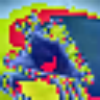

-----------

plane


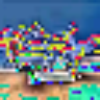

-----------

plane


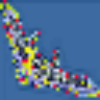

-----------

plane


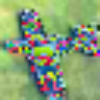

-----------

plane


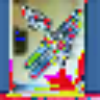

-----------

car


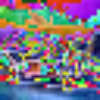

-----------

car


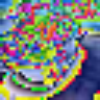

-----------

car


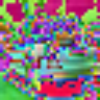

-----------

car


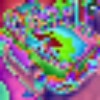

-----------

car


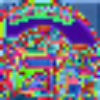

-----------



In [23]:
for idx in range (0, len(train_dataset),1000):
    display_image(train_dataset, idx)

## Create Data Loader
In Pytorch a Dataloader takes a <i>torch.utils.data.Dataset</i> object as an input along with hyper params such as batch size.



The Number of workers (num_workers) is optimised depending on the hardware this is run on, generally optimal settings are slightly less than the number of threads available.

[Pytorch Documentation](https://pytorch.org/docs/stable/data.html)

In [24]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

## Create Test Function

This function receives a dataloader, model and loss function, then loops through the dataloader calculating loss and accuracy then returning the averages of these for the whole epoch.

Calling __torch.no_grad()__ results in the gradients of the model not being recorded.

__running_acc__ is updated with a calculation that rounds the second column of the prediction and compares that to the ground truth returning the percentage that were correct.

In [25]:
def test_single_epoch(device, dataloader, model, loss_fn):
   
    #zero accumulating values for los and acc
    running_acc = 0.0
    running_loss = 0.0
    
    #set model to  eval state
    with torch.no_grad():

        # Iterate over data and test
        for batch, gnd_truth in dataloader:

            #Send to gpu or cpu
            batch, gnd_truth = batch.to(device), gnd_truth.to(device)

            # forward
            preds = model(batch)

            #get loss
            loss = loss_fn(preds, gnd_truth)

            # update running loss and acc
            running_acc += (torch.round(preds[:,1]).unsqueeze(1)  == gnd_truth.unsqueeze(1)).sum()/ gnd_truth.unsqueeze(1).shape[0]
            running_loss += loss.item()
            

    return float(running_loss/len(dataloader)), float(running_acc/len(dataloader))

## Create Train Function

Training is very similar to the test function above with some key differences, we call __model.train()__ at the start so the model knows to collect gradients, we also need to clear the gradents at the start of each batch with  __optimizer.zero_grad()__ then after calculating the loss we call __loss.backward()__  to calculate the gradients for all of the parameters (tensors) in the model.
 
Finaly we call __optimizer.step()__ to get the optimizer to iterate over all parameters (tensors) it is set to update, the stored gradents from the last steps are used.

In [26]:
def train_single_epoch(device, dataloader, model, loss_fn, optimizer):
    
    #zero accumulating values for los and acc
    running_acc = 0.0
    running_loss = 0.0
    
    #set model to train state
    model.train()

    # Iterate over data and train
    for batch, gnd_truth in dataloader:
        
        #Send to gpu or cpu
        batch, gnd_truth = batch.to(device), gnd_truth.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad() 
        
        # forward
        preds = model(batch)
        
        #get loss
        loss = loss_fn(preds, gnd_truth)
        
        #backward
        loss.backward()
        
        #optimize
        optimizer.step()

        # update running loss and acc
        running_acc += (torch.round(preds[:,1]).unsqueeze(1)  == gnd_truth.unsqueeze(1)).sum()/ gnd_truth.unsqueeze(1).shape[0]
        running_loss += loss.item()

        
    return model, float(running_loss/len(dataloader)), float(running_acc/len(dataloader))

## Run Validation Function to get a Baseline Before Training the Model

The final layer is randomly initated so we would expect the outputs to be roughtly random or about the same as a coin flip or 50 %

In [27]:
val_loss, val_acc = test_single_epoch(device, val_data_loader, model, loss_fn)
print('val_loss: {:.4f}'.format(val_loss))
print('val_acc: {:.4f}'.format(val_acc))

val_loss: 0.6989
val_acc: 0.4910


## Set Trainable Layers

In order to be able to first train the new layers, then fine tune the whole model, we set the layers we are targeting to record gradents using __requires_grad = True__ and the layers we want to leave untouched to __requires_grad = False__. It also provides an opportunity to view the model in a different way.

In [28]:
for named_param in model.named_parameters():
    if 'fc' in  named_param[0]:
        print('Will train', named_param[0])
        named_param[1].requires_grad = True
    else:
        print('Won\'t train', named_param[0])  
        named_param[1].requires_grad = False

Won't train conv1.weight
Won't train bn1.weight
Won't train bn1.bias
Won't train layer1.0.conv1.weight
Won't train layer1.0.bn1.weight
Won't train layer1.0.bn1.bias
Won't train layer1.0.conv2.weight
Won't train layer1.0.bn2.weight
Won't train layer1.0.bn2.bias
Won't train layer1.1.conv1.weight
Won't train layer1.1.bn1.weight
Won't train layer1.1.bn1.bias
Won't train layer1.1.conv2.weight
Won't train layer1.1.bn2.weight
Won't train layer1.1.bn2.bias
Won't train layer2.0.conv1.weight
Won't train layer2.0.bn1.weight
Won't train layer2.0.bn1.bias
Won't train layer2.0.conv2.weight
Won't train layer2.0.bn2.weight
Won't train layer2.0.bn2.bias
Won't train layer2.0.downsample.0.weight
Won't train layer2.0.downsample.1.weight
Won't train layer2.0.downsample.1.bias
Won't train layer2.1.conv1.weight
Won't train layer2.1.bn1.weight
Won't train layer2.1.bn1.bias
Won't train layer2.1.conv2.weight
Won't train layer2.1.bn2.weight
Won't train layer2.1.bn2.bias
Won't train layer3.0.conv1.weight
Won't tr

## Training and Validating

The train loop runs the <i>Train</i> then <i>Validate</i> functions and collects the results. This example shows a fairly simple loop that collects the returns from the fuctions and stores them in arrays. The loss is also printed out every other epoch.

This is the part when we can define actions taken between epochs including saving checkpoints of the model or using [MLFlow](https://mlflow.org/) to log [metrics](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_metric) from the epoch.

As we aren't using a tool to track the course of the training, we will first setup some arrays to track the model performance and metrics over the course of the training.

In [29]:
train_acc_hist = []
train_loss_hist = []
val_acc_hist = []
val_loss_hist = []

### Model Performance Review
Before we do any training we pass the Train and Validation datasets through the testing function to get a baseline so we can see how much of an improvement we make.

In [30]:
train_loss, train_acc = test_single_epoch(device, train_data_loader, model, loss_fn)
train_acc_hist.append(train_acc)
train_loss_hist.append(train_loss)

val_loss, val_acc = test_single_epoch(device, val_data_loader, model, loss_fn)
val_acc_hist.append(val_acc) #append results to the array we are using for tracking 
val_loss_hist.append(val_loss) #append results to the array we are using for tracking 

#
print('Inital Model State')
print('train_loss: {:.4f}'.format(train_loss))
print('val_loss: {:.4f}'.format(val_loss))
print('train_acc: {:.4f}'.format(train_acc))
print('val_acc: {:.4f}'.format(val_acc))

Inital Model State
train_loss: 0.7027
val_loss: 0.7028
train_acc: 0.4667
val_acc: 0.4720


### Train New Layers
First we start off by training just the new layers we added to the end of the model, the rest of the layers are already trained so we want to start with just the new ones. This only needs a few of epochs before we start to see reasonable accuracy, we will use 6 for this example.

In [31]:
print('------------------------------------------------------------------------')
print('starting training for {} epochs '.format(last_layer_epochs))
print('------------------------------------------------------------------------')

for epoch in range(1, last_layer_epochs + 1):  # loop over the dataset multiple times
    
    model, train_loss, train_acc = train_single_epoch(device, train_data_loader, model, loss_fn, optimizer)
    train_acc_hist.append(train_acc) #append results to the array we are using for tracking 
    train_loss_hist.append(train_loss) #append results to the array we are using for tracking 
    
    val_loss, val_acc = test_single_epoch(device, val_data_loader, model, loss_fn)
    val_acc_hist.append(val_acc) #append results to the array we are using for tracking 
    val_loss_hist.append(val_loss) #append results to the array we are using for tracking 
    
    #Print out every epoch
    print('finished training for epoch {}'.format(epoch))
    print('train_loss: {:.4f}'.format(train_loss))
    print('val_loss: {:.4f}'.format(val_loss))
    print('train_acc: {:.4f}'.format(train_acc))
    print('val_acc: {:.4f}'.format(val_acc))
    print('------------------------------------------------------------------------')

------------------------------------------------------------------------
starting training for 2 epochs 
------------------------------------------------------------------------
finished training for epoch 1
train_loss: 0.5542
val_loss: 0.5555
train_acc: 0.7437
val_acc: 0.7380
------------------------------------------------------------------------
finished training for epoch 2
train_loss: 0.5320
val_loss: 0.5337
train_acc: 0.7639
val_acc: 0.7680
------------------------------------------------------------------------


### Check Model Performance
Again we have a look at the performance of the model against the train and val datasets. No training is perfomed in this step.

In [32]:
train_loss, train_acc = test_single_epoch(device, train_data_loader, model, loss_fn)
train_acc_hist.append(train_acc)
train_loss_hist.append(train_loss)

val_loss, val_acc = test_single_epoch(device, val_data_loader, model, loss_fn)
val_acc_hist.append(val_acc)
val_loss_hist.append(val_loss)
print('Current Model State')
print('train_loss: {:.4f}'.format(train_loss))
print('Val dataset loss: {:.4f}'.format(val_loss))
print('train_acc: {:.4f}'.format(train_acc))
print('Val dataset acc: {:.4f}'.format(val_acc))

Current Model State
train_loss: 0.5203
Val dataset loss: 0.5146
train_acc: 0.7824
Val dataset acc: 0.7865


### Set Trainable Layers

Now that we have trained the new layers we can start to finetune the entire model, we set all layers to __.requires_grad = True__

In [33]:
for named_param in model.named_parameters():
    named_param[1].requires_grad = True

### Train All Layers

Next we run a training loop to train all the layers, in this example the train process is spread out across several loops. In a real example this would likely be incorporated into a class or function to call as required.

In [34]:
print('------------------------------------------------------------------------')
print('starting training for {} epochs '.format(all_layer_epochs))
print('------------------------------------------------------------------------')

for epoch in range(1, all_layer_epochs + 1):  # loop over the dataset multiple times
    
    model, train_loss, train_acc = train_single_epoch(device, train_data_loader, model, loss_fn, optimizer)
    train_acc_hist.append(train_acc) #append results to the array we are using for tracking 
    train_loss_hist.append(train_loss) #append results to the array we are using for tracking 
    
    val_loss, val_acc = test_single_epoch(device, val_data_loader, model, loss_fn)
    val_acc_hist.append(val_acc) #append results to the array we are using for tracking 
    val_loss_hist.append(val_loss) #append results to the array we are using for tracking 
    
    if (epoch % 3) == 0: #Print out every third epoch 
        print('finished training for epoch {}'.format(epoch))
        print('train_loss: {:.4f}'.format(train_loss))
        print('val_loss: {:.4f}'.format(val_loss))
        print('train_acc: {:.4f}'.format(train_acc))
        print('val_acc: {:.4f}'.format(val_acc))
        print('------------------------------------------------------------------------\n\n')

------------------------------------------------------------------------
starting training for 15 epochs 
------------------------------------------------------------------------
finished training for epoch 3
train_loss: 0.4464
val_loss: 0.4307
train_acc: 0.8636
val_acc: 0.8825
------------------------------------------------------------------------


finished training for epoch 6
train_loss: 0.4023
val_loss: 0.3960
train_acc: 0.9082
val_acc: 0.9165
------------------------------------------------------------------------


finished training for epoch 9
train_loss: 0.3918
val_loss: 0.3997
train_acc: 0.9200
val_acc: 0.9125
------------------------------------------------------------------------


finished training for epoch 12
train_loss: 0.3797
val_loss: 0.3925
train_acc: 0.9335
val_acc: 0.9210
------------------------------------------------------------------------


finished training for epoch 15
train_loss: 0.3962
val_loss: 0.4051
train_acc: 0.9150
val_acc: 0.9045
-------------------

### Final Model Performance Review
Now we run a final test of the train and validation datsets to see the end result of our training.

In [35]:
train_loss, train_acc = test_single_epoch(device, train_data_loader, model, loss_fn)
train_acc_hist.append(train_acc)
train_loss_hist.append(train_loss)

val_loss, val_acc = test_single_epoch(device, val_data_loader, model, loss_fn)
val_acc_hist.append(val_acc)
val_loss_hist.append(val_loss)
print('Final Model State')
print('Train  dataset loss: {:.4f}'.format(train_loss))
print('Val dataset loss: {:.4f}'.format(val_loss))
print('Train  dataset acc: {:.4f}'.format(train_acc))
print('Val dataset acc: {:.4f}'.format(val_acc))

Final Model State
Train  dataset loss: 0.4023
Val dataset loss: 0.3999
Train  dataset acc: 0.9097
Val dataset acc: 0.9120


## Review Loss over the Epochs

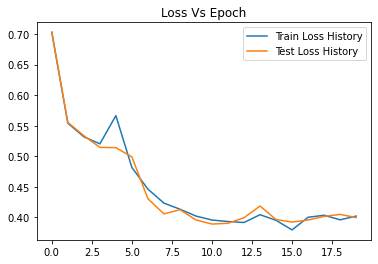

In [36]:
train_loss_plt, = plt.plot(train_loss_hist)
val_loss_plt, = plt.plot(val_loss_hist)
plt.title("Loss Vs Epoch")
plt.legend([train_loss_plt, val_loss_plt], ['Train Loss History', 'Test Loss History'])

## Review Accuracy over the Epochs

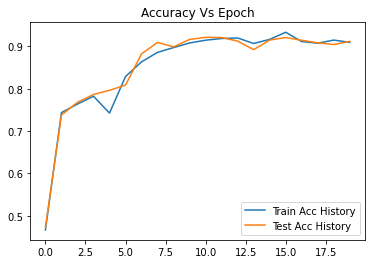

In [37]:
train_acc_hist_plt, = plt.plot(train_acc_hist)
val_acc_hist_plt, = plt.plot(val_acc_hist)
plt.title("Accuracy Vs Epoch")
plt.legend([train_acc_hist_plt, val_acc_hist_plt], ['Train Acc History', 'Test Acc History'])

## Final thoughts

We can see from these charts that the accuracy improves from about random at the start (which is to be expected as the last layers where randomly initialised) to about 78% after training the new layers then to over 90% after fine-tuning the whole model.

This model could be further optimised, specifically things like the batch size, learning rate, model selection and design of the output layers to suit specific tasks.